# Lab 10 - Auto-Encoders and Variational Encoder

### Q1

Epoch [1/10], Loss: 0.0392
Epoch [2/10], Loss: 0.0137
Epoch [3/10], Loss: 0.0099
Epoch [4/10], Loss: 0.0080
Epoch [5/10], Loss: 0.0069
Epoch [6/10], Loss: 0.0060
Epoch [7/10], Loss: 0.0054
Epoch [8/10], Loss: 0.0050
Epoch [9/10], Loss: 0.0046
Epoch [10/10], Loss: 0.0043


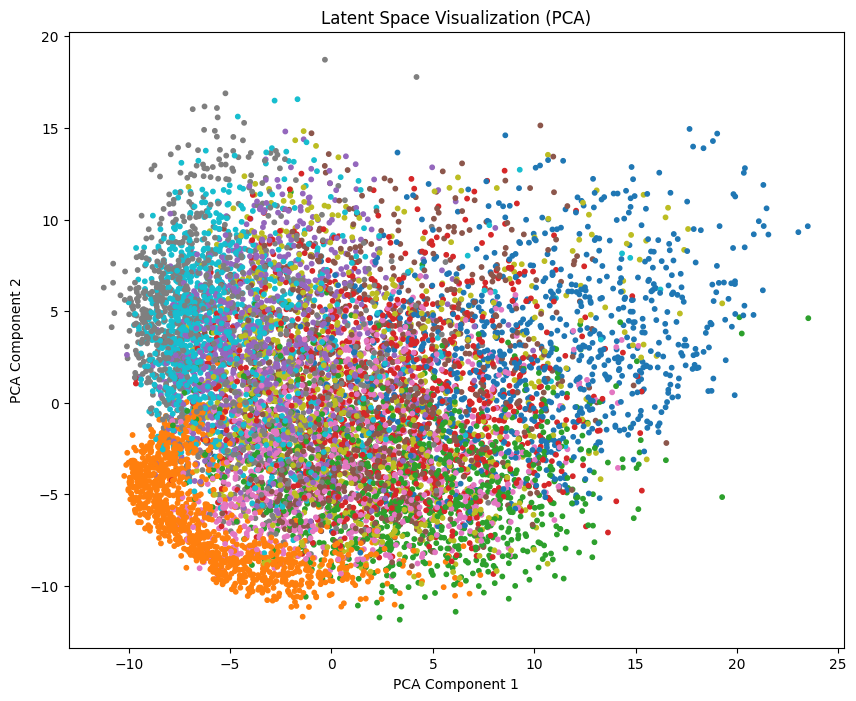

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(), 
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    def encode(self, x):
        return self.encoder(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(latent_dim=64).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        z = model.encode(imgs)
        latent_vectors.append(z.cpu())
        labels.extend(lbls.numpy())

latent_vectors = torch.cat(latent_vectors).numpy()  # Concatenate latent vectors
labels = np.array(labels)

pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Q2

Epoch [1/10], Loss: 22906.3304
Epoch [2/10], Loss: 17193.1158
Epoch [3/10], Loss: 15681.1723
Epoch [4/10], Loss: 14922.1420
Epoch [5/10], Loss: 14495.0878
Epoch [6/10], Loss: 14251.5650
Epoch [7/10], Loss: 14080.6003
Epoch [8/10], Loss: 13961.5234
Epoch [9/10], Loss: 13879.3904
Epoch [10/10], Loss: 13805.4085


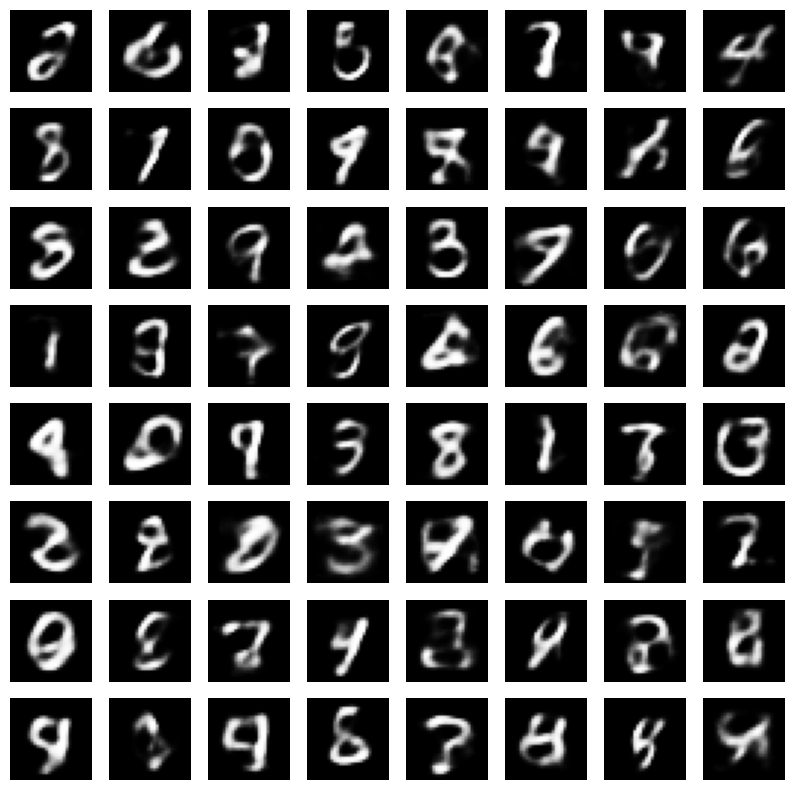

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.Encoder = nn.Sequential(
            nn.Linear(784, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 100, bias=True),
            nn.Sigmoid(),
        )

        self.mean = nn.Linear(100, 10, bias=True)
        self.std = nn.Linear(100, 10, bias=True)

        self.Decoder = nn.Sequential(
            nn.Linear(10, 100, bias=True),  
            nn.ReLU(),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 784, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)  
        enc = self.Encoder(x)
        mean = self.mean(enc)
        std = self.std(enc)
        z = mean + std * torch.randn_like(std)
        y = self.Decoder(z)
        return mean, std, y.view(-1, 1, 28, 28)  

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

model = VariationalAutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(epoch_index):
    model.train()
    total_loss = 0.

    for i, data in enumerate(train_data_loader):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        mean, std, outputs = model(inputs)
        loss = loss_function(inputs.view(batch_size, -1), outputs.view(batch_size, -1), mean, std)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_data_loader.dataset)
    print(f"Epoch [{epoch_index+1}], Loss: {avg_loss:.4f}")
    return avg_loss

num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(epoch)

def generate_digit():
    mean = torch.zeros((1, 10)).to(device)
    var = torch.ones((1, 10)).to(device)
    z_sample = mean + var * torch.randn_like(var)
    x_decoded = model.Decoder(z_sample)  # No BatchNorm1d now

    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit()
generate_digit()